In [ ]:
import numpy as np
import os
import cv2 as cv
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import datetime

In [3]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [4]:
import albumentations as A

In [5]:
train_label_csv = pd.read_csv("/kaggle/input/rockfall-detection-on-moon/moon/train_labels/train_labels_m.csv")

In [6]:
train_label_csv.tail()

,IMAGE_ID,X1,Y1,X2,Y2,label
1295,neg296.tif,NaN,NaN,NaN,NaN,NaN
1296,neg297.tif,NaN,NaN,NaN,NaN,NaN
1297,neg298.tif,NaN,NaN,NaN,NaN,NaN
1298,neg299.tif,NaN,NaN,NaN,NaN,NaN
1299,neg300.tif,NaN,NaN,NaN,NaN,NaN


In [7]:
train_label_csv.describe

<bound method NDFrame.describe of         IMAGE_ID     X1     Y1     X2     Y2     label
0          1.tif  148.0   40.0  183.0  125.0  rockfall
1         10.tif  214.0  159.0  287.0  209.0  rockfall
2         10.tif  553.0  192.0  596.0  229.0  rockfall
3         11.tif  418.0   58.0  452.0   88.0  rockfall
4         11.tif  421.0  141.0  468.0  182.0  rockfall
...          ...    ...    ...    ...    ...       ...
1295  neg296.tif    NaN    NaN    NaN    NaN       NaN
1296  neg297.tif    NaN    NaN    NaN    NaN       NaN
1297  neg298.tif    NaN    NaN    NaN    NaN       NaN
1298  neg299.tif    NaN    NaN    NaN    NaN       NaN
1299  neg300.tif    NaN    NaN    NaN    NaN       NaN

[1300 rows x 6 columns]>

In [8]:
''' Last 300 rows are empty'''
train_label_csv1 = train_label_csv.iloc[:1001]

In [9]:
train_label_csv1.tail()

,IMAGE_ID,X1,Y1,X2,Y2,label
996,360.tif,123.0,291.0,158.0,371.0,rockfall
997,360.tif,203.0,196.0,264.0,282.0,rockfall
998,360.tif,272.0,67.0,310.0,141.0,rockfall
999,360.tif,354.0,140.0,406.0,206.0,rockfall
1000,neg1.tif,NaN,NaN,NaN,NaN,NaN


In [10]:
test_label_csv = pd.read_csv("/kaggle/input/rockfall-detection-on-moon/moon/test_labels/test_labels_m.csv")

(185, 369, 3)
1.tif 148.0 40.0 183.0 125.0
(185, 369, 3)
0.8130081300813008 1.6216216216216217
1.tif 148.0 40.0 183.0 125.0


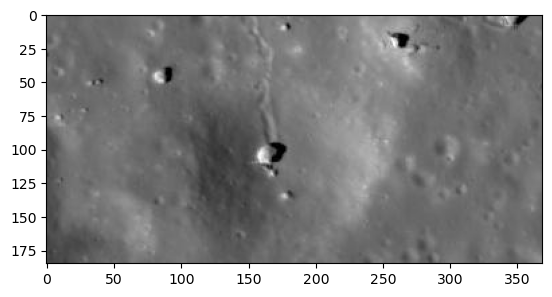

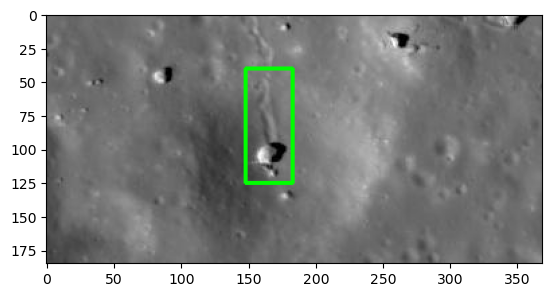

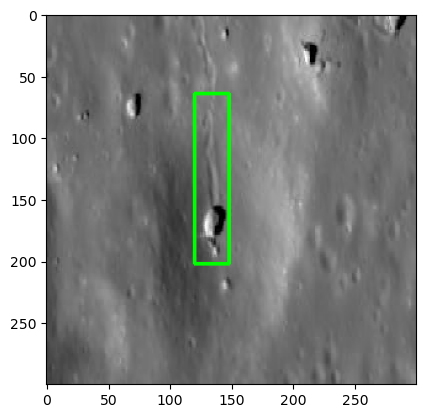

In [11]:
'''Normal Image plotting'''
df_antt= train_label_csv
img1= cv.imread("/kaggle/input/rockfall-detection-on-moon/moon/train_images/1.tif")
plt.figure()
plt.imshow(img1)

'''Image with its bounding box co-ordinates '''
im = cv.imread("/kaggle/input/rockfall-detection-on-moon/moon/train_images/1.tif")
for i in range(1):
    print(df_antt['IMAGE_ID'][i],df_antt['X1'][i],df_antt['Y1'][i],df_antt['X2'][i],df_antt['Y2'][i])
    start_point = (int(df_antt['X1'][i]), int(df_antt['Y1'][i]))
    end_point = (int(df_antt['X2'][i]), int(df_antt['Y2'][i]))
    cv.rectangle(im, start_point, end_point, color=(0,255,0), thickness=2)
plt.figure()
plt.imshow(im[...,::-1])

'''Resized Image with bbox co-ordinates'''
imx = cv.imread("/kaggle/input/rockfall-detection-on-moon/moon/train_images/1.tif")
im = cv.resize(imx,(300,300),interpolation = cv.INTER_NEAREST)
scale_factor_w = 300 / imx.shape[1]
scale_factor_h = 300 / imx.shape[0]
print(scale_factor_w,scale_factor_h)
for i in range(1):
    print(df_antt['IMAGE_ID'][i],df_antt['X1'][i],df_antt['Y1'][i],df_antt['X2'][i],df_antt['Y2'][i])
    start_point = (int(df_antt['X1'][i]*scale_factor_w), int(df_antt['Y1'][i]*scale_factor_h))
    end_point = (int(df_antt['X2'][i]*scale_factor_w), int(df_antt['Y2'][i]*scale_factor_h))
    cv.rectangle(im, start_point, end_point, color=(0,255,0), thickness=2)
plt.figure()
plt.imshow(im[...,::-1])

In [13]:
dataset_path= '/kaggle/input/rockfall-detection-on-moon/moon/'
max_boxes = 20
""" Loading labels """
classes = ['rockfall']
num_classes = len(classes)
def load_data(path, classes, train=True):
    
    """ This function extracts the images and bounding boxes from csv file. It also segregates the images with Nan values
        and only considers the images having the bounding box co-ordinates.
        
        You can check training samples by simply passing Train = True
        for testing samples pass Train = False
        """
    
    images = []
    bboxes = []
    same_img_bbox=[]
    ''' Creating a separate list of nan values which can be utilised later on.'''
    extra_images=[]
    
    if train == True:
        df = train_label_csv
    else:
        df = test_label_csv
        
    prev_name=''
    flag=0
    name_changed=False
    counter=0
    for index, row in df.iterrows():
        
        try:
            if (row[1:6] != np.nan).all():
                    
                    name = row[0]
#                     print("NAME : ",name)
                    if prev_name != name:
                        prev_name = name
                        name_changed=True
#                         print("NAME CHANGED")
                        if len(same_img_bbox)==1:
                            same_img_bbox_padded = tf.pad(same_img_bbox, [(0, max_boxes - len(same_img_bbox)), (0, 0)], mode='CONSTANT')
                            bboxes.append(same_img_bbox_padded.numpy()) #for the format
                        elif len(same_img_bbox)>1:
#                             bboxes.append(same_img_bbox) 
                            same_img_bbox_padded = tf.pad(same_img_bbox, [(0, max_boxes - len(same_img_bbox)), (0, 0)], mode='CONSTANT')
                            bboxes.append(same_img_bbox_padded.numpy()) #for the format
                        same_img_bbox=[]
                    
#                     print("PREV NAME :",prev_name)
                    x1 = int(row[1])
                    y1 = int(row[2])
                    x2 = int(row[3])
                    y2 = int(row[4])
                    label_name = row[5]

                    if train == True:
                        image_path = os.path.join(path, "train_images", prev_name)
                    else:
                        image_path = os.path.join(path, "test_images", prev_name)

                    bbox_list = [x1, y1, x2, y2]
#                     print("CO_ORDINATES")

                    if name_changed:
                        images.append(image_path)
                        same_img_bbox.append(np.float32(bbox_list))
#                         print("NAME SAVED")
                
                    else:
                        same_img_bbox.append(np.float32(bbox_list))
#                         print("NAME IS SAME")
                    name_changed=False
        except:
                    if train == True:
                        image_path = os.path.join(path, "train_images", name)
                    else:
                        image_path = os.path.join(path, "test_images", name)

                    extra_images.append(image_path)
#         counter+=1
#         if counter>20:
#             break
    return images, bboxes,extra_images

images, bboxes,extra_images = load_data(dataset_path, classes, train=True)

In [14]:
print(len(images))
print(len(extra_images))
print(len(bboxes))
print(bboxes[0])
print(images[0])


349
300
349
[[148.  40. 183. 125.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]]
/kaggle/input/rockfall-detection-on-moon/moon/train_images/1.tif


/kaggle/input/rockfall-detection-on-moon/moon/train_images/1.tif


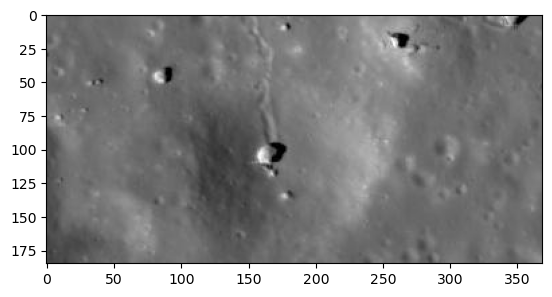

In [15]:
image=cv.imread(images[0])
plt.imshow(image)
print(images[0])

In [16]:
def load_dataset(path, classes, split=0.1):
    ''' load_dataset splits data into training and validation'''
    ''' It also increases the samples by invoking the data_augmentation finction'''
    
    images, bboxes,extra_train_imgs = load_data(path, classes, train=True)

    '''Augmentation'''
    train_images,train_bboxes = data_augmentation(images,bboxes) #valid set will also contain transformed images!! 
    
    """ Split into training, validation """
    
    print ('After AUgmentation : ',len(train_images),len(train_bboxes))
    
    split_size = int(len(train_images) * split)

    '''Train Test and split '''
    train_images, valid_images = train_test_split(train_images, test_size=split_size, random_state=42)
    train_bboxes, valid_bboxes = train_test_split(train_bboxes, test_size=split_size, random_state=42)
    test_images, test_bboxes,extra_test_imgs = load_data(path, classes, train=False)

    extra_test_imgs.extend(extra_train_imgs)
    
    return (train_images, train_bboxes), (valid_images, valid_bboxes), (test_images, test_bboxes), extra_test_imgs


In [18]:
'''Transformation Pipeline for Data Augmentation'''
global transform
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
#     A.Flip(),
    A.HorizontalFlip(p=0.5),
#     A.Transpose(),
    A.OneOf([
        A.GaussNoise(),
        A.GaussianBlur(),
        A.MotionBlur(),
    ], p=0.3),
    A.OneOf([
        A.RandomBrightnessContrast(),
        A.ColorJitter(),
    ], p=0.2),
    A.OneOf([
        A.OpticalDistortion(),
        A.ElasticTransform(),
        A.GridDistortion(),
        A.Perspective(),
    ], p=0.25),
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))


In [19]:
'''DATA AUGMENTATION'''
'''Here new samples are created and image preprocessing is done according to MobileNet V2'''

def data_augmentation(image_path_list,image_bbox_list):
    
    new_images_list = []
    new_bboxes_list = []
    max_bboxes = 20
    
    for path,bbox in zip(image_path_list,image_bbox_list):

        image = cv.imread(path)
        image = cv.resize(image, (300, 300),interpolation = cv.INTER_NEAREST)
        image = (image - 127.5) / 127.5 ## [-1, +1]
        image = image.astype(np.float32)
        h, w, _ = image.shape
        scale_factor_w = 300 / image.shape[1]
        scale_factor_h = 300 / image.shape[0]
#         plt.imshow(image)
        bbox_list = bbox

        '''After resizing image bbox co-ordinates are resized accordingly'''
        bbox_list_resize = [[bbox[0]*scale_factor_w, bbox[1]*scale_factor_h, bbox[2]*scale_factor_w, bbox[3]*scale_factor_h] for bbox in bbox_list]
        bbox_list_normalized = [[bbox[0]/w, bbox[1]/h, bbox[2]/w, bbox[3]/h] for bbox in bbox_list_resize]
        bboxes = tf.convert_to_tensor(bbox_list_normalized, dtype=tf.float32)

        mask = tf.reduce_all(bboxes != 0.0, axis=1)
        filtered_bboxes = tf.boolean_mask(bboxes, mask)
        classes = [0]*len(filtered_bboxes)
       
        ''' This for loop generates new samples form existing image and add extra padding of 0s to make list 
        of same length'''
        for i in range(6):
            transformed = transform(image=image, bboxes=filtered_bboxes , class_labels=classes)
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']
            padded_bboxes = []
            for j in range(max_bboxes):
                if j < len(transformed_bboxes):
                    padded_bboxes.append(transformed_bboxes[j])
                else:
                    padded_bboxes.append([0.0, 0.0, 0.0, 0.0])
            transformed_bbox_tensor = tf.convert_to_tensor(padded_bboxes, dtype=tf.float32)
            new_images_list.append(transformed_image)
            new_bboxes_list.append(transformed_bbox_tensor)


    return new_images_list ,new_bboxes_list
# kl,hj = data_augmentation(images[0:10],bboxes[0:10])

In [22]:
'''This function is used to read image and bbox when batches are made'''
def read_image_bbox(img, bbox):  
  
    """ Image """
    image = img
    transformed_image = image
  
    """ Bounding box """
    bbox_list_normalized =bbox 
    return transformed_image, bbox_list_normalized


In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [24]:

def parse(image, bbox):
    ''' Parse will connect numpy with tensorflow and we can create tensors out of numpy arrays'''
    image, bbox = tf.numpy_function(read_image_bbox, [image, bbox], [tf.float32, tf.float32])
    image.set_shape((height, width, 3))
    bbox.set_shape((max_boxes,4))
    return (image), (bbox)


def tf_dataset(images, bboxes, batch=8):
    ''' It creates the dataset'''
    ds = tf.data.Dataset.from_tensor_slices((images, bboxes))
    ds = ds.map(parse).batch(batch).prefetch(AUTOTUNE)
    return ds

In [25]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)


""" Hyperparameters """
height = 300
width = 300
batch_size = 16
lr = 1e-2
num_epochs = 30
max_boxes = 20

In [26]:
""" Dataset """
(train_images, train_bboxes), (valid_images, valid_bboxes), (test_images, test_bboxes),Extra_test_images= load_dataset(dataset_path, classes, split=0.2)
print(f"Train: {len(train_images)} - {len(train_bboxes)}")
print(f"Valid: {len(valid_images)} - {len(valid_bboxes)}")
print(f"Test : {len(test_images)} - {len(test_bboxes)}")


After AUgmentation :  2094 2094
Train: 1676 - 1676
Valid: 418 - 418
Test : 17 - 17


In [28]:

train_images_tensor = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_bboxes_tensor = tf.convert_to_tensor(train_bboxes, dtype=tf.float32)

'''Creating Dataset by chaining all functions together'''
train_ds = tf_dataset(train_images_tensor, train_bboxes_tensor, batch=batch_size)
print(len(train_ds))
valid_ds = tf_dataset(valid_images, valid_bboxes, batch=batch_size)


105


In [30]:
import tensorflow.keras.backend as K
'''Smooth L1 Loss as loss function for code'''
def smooth_l1_loss(y_true, y_pred):
    delta = 1.0
    x = K.abs(y_true - y_pred)
    mask = K.cast(K.less(x, delta), dtype='float32')
    loss = (mask * 0.5 * x**2) + (1 - mask) * (x - 0.5 * delta)
    return K.mean(loss, axis=-1)

In [31]:
## MULTI BOX MODEL
global max_boxes
def build_model(input_shape, num_classes=1, max_boxes=20):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Backbone """
    backbone = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        alpha=1.0
    )
    backbone.trainable = True
    # backbone.summary()

    """ Detection Head """
    x = backbone.output
    x = L.Conv2D(256, kernel_size=1, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Dropout(0.2)(x)
    x = L.GlobalAveragePooling2D()(x)
    bbox = L.Dense(max_boxes * 4, activation="sigmoid", name="bbox")(x)
    bbox = L.Reshape((max_boxes, 4))(bbox)
#     label = L.Dense(num_classes, activation="softmax", name="label")(x)

    """ Model """
    model = Model(inputs=[inputs], outputs=[bbox])
    return model

In [33]:
""" Model """
model = build_model((height, width, 3))

'''Compiling Model'''
model.compile(
    
    loss = {
        "reshape": smooth_l1_loss,
    },
    optimizer=Adam(lr)

)
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

'''Callbacks'''
callbacks = [

    ModelCheckpoint(filepath=f'models/ObjectDetectionModel_{current_datetime}.h5', verbose=0,save_best_model=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=0),
    CSVLogger(filename=f'models/ModelStats_{current_datetime}.csv', append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

'''Fitting the data and training begins from here'''
model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=valid_ds,
    callbacks=callbacks
)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/30


2023-05-19 20:36:43.347999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


105/105 [==============================] - 52s 185ms/step - loss: 5.5493 - val_loss: 3.7544 - lr: 0.0100
Epoch 2/30
105/105 [==============================] - 17s 160ms/step - loss: 5.5475 - val_loss: 3.7533 - lr: 0.0100
Epoch 3/30
105/105 [==============================] - 17s 164ms/step - loss: 5.5467 - val_loss: 3.7544 - lr: 0.0100
Epoch 4/30
105/105 [==============================] - 17s 167ms/step - loss: 5.5474 - val_loss: 3.7535 - lr: 0.0100
Epoch 5/30
105/105 [==============================] - 18s 168ms/step - loss: 5.5470 - val_loss: 3.7548 - lr: 0.0100
Epoch 6/30
105/105 [==============================] - 17s 159ms/step - loss: 5.5466 - val_loss: 3.7554 - lr: 0.0100
Epoch 7/30
105/105 [==============================] - 17s 159ms/step - loss: 5.5466 - val_loss: 3.7487 - lr: 0.0100
Epoch 8/30
105/105 [==============================] - 17s 164ms/step - loss: 5.5460 - val_loss: 3.7495 - lr: 0.0100
Epoch 9/30
105/105 [==============================] - 17s 164ms/step - loss: 5.5470

In [34]:
""" Global parameters """
global height
global width
global num_classes
global label_names

In [35]:
'''IoU Calculation'''
def cal_iou(y_true, y_pred):
    mean_iou=[]
    for target, predict in zip(y_true, y_pred):
        x1 = max(target[0], predict[0])
        y1 = max(target[1], predict[1])
        x2 = min(target[2], predict[2])
        y2 = min(target[3], predict[3])

        intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

        true_area = (target[2] - target[0] + 1) * (target[3] - target[1] + 1)
        bbox_area = (predict[2] - predict[0] + 1) * (predict[3] - predict[1] + 1)

        iou = intersection_area / float(true_area + bbox_area - intersection_area)
        mean_iou.append(iou)
    return iou,mean_iou

In [36]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

files='/kaggle/working/models/'
model_path = os.path.join(f"{files}", f"ObjectDetectionModel_{current_datetime}.h5")

""" Load the model """
model = tf.keras.models.load_model(model_path,custom_objects={"smooth_l1_loss":smooth_l1_loss})

ENter the num :  1 2 3 4 5 6 7 8 9 10 11 1 2 13 1 4 15 16 17


<Figure size 640x480 with 0 Axes>

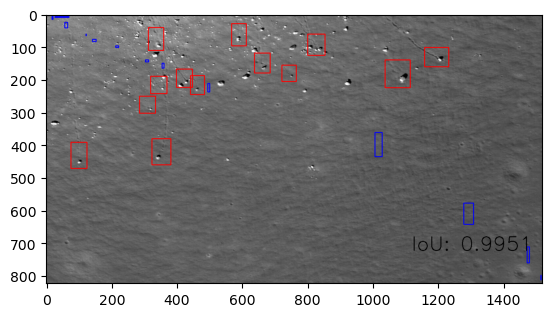

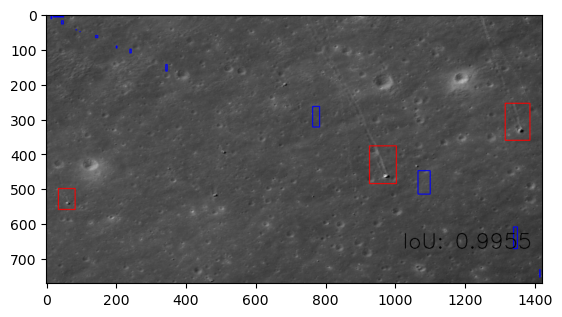

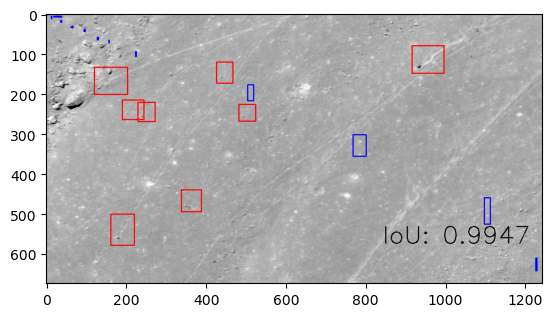

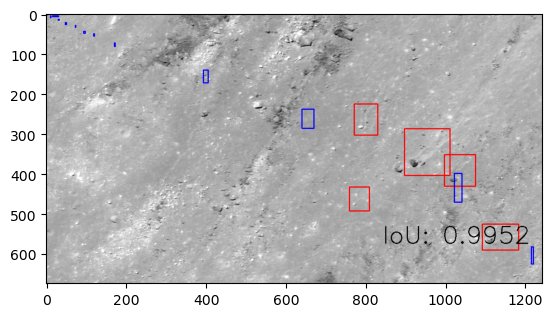

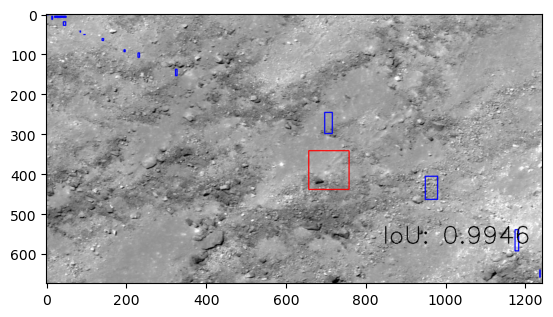

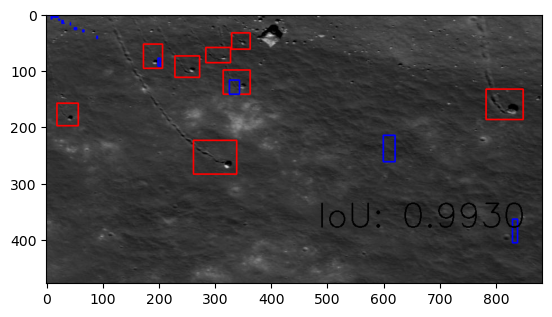

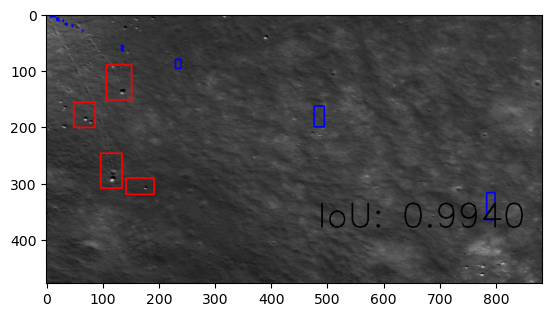

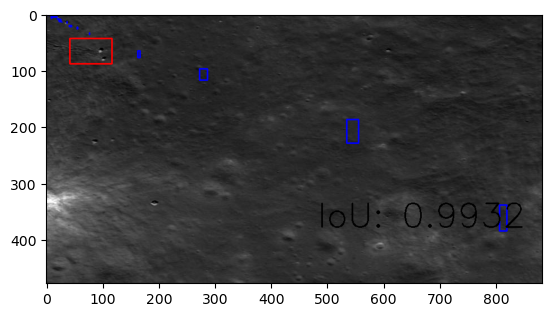

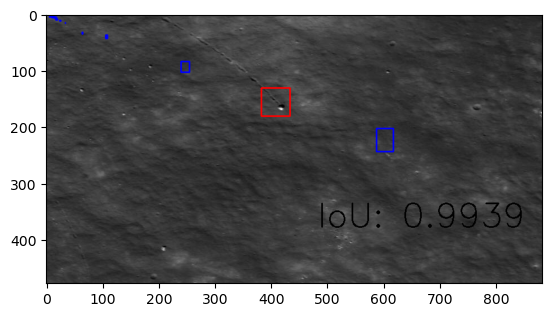

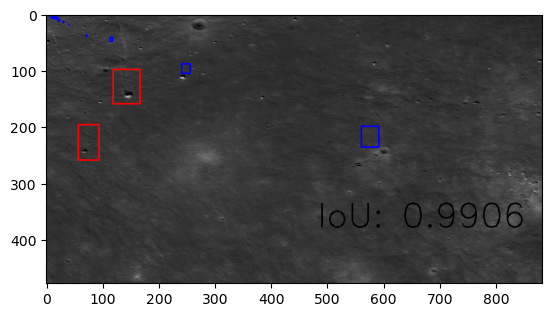

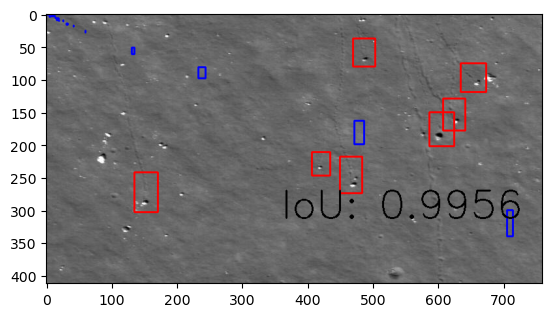

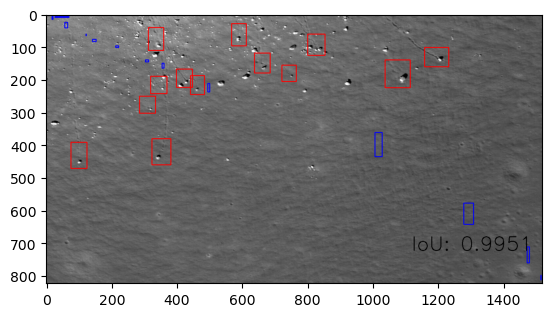

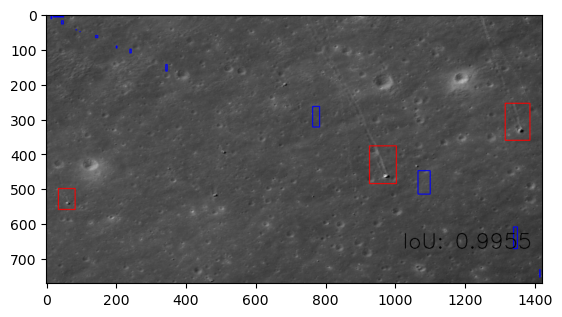

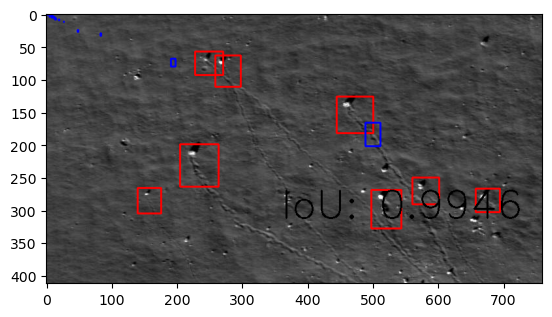

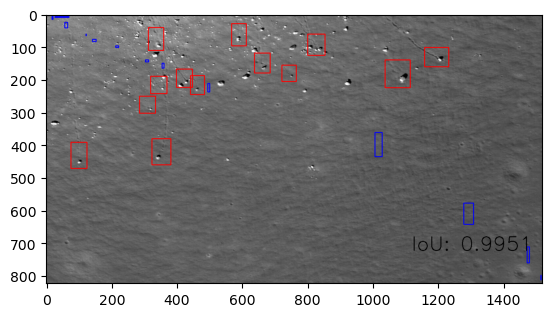

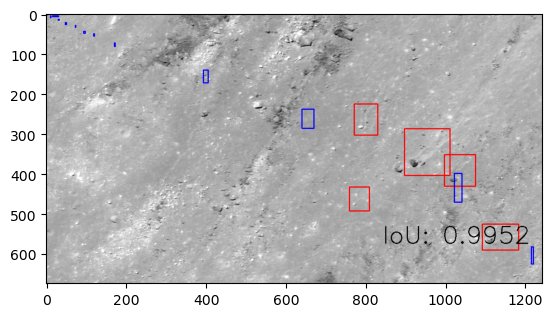

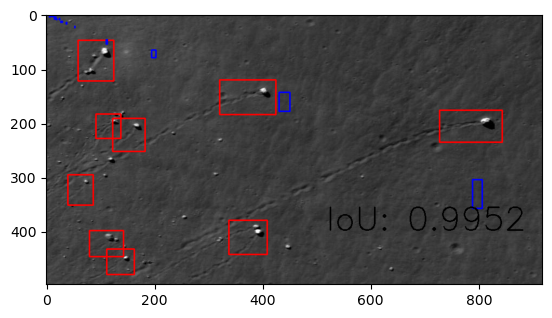

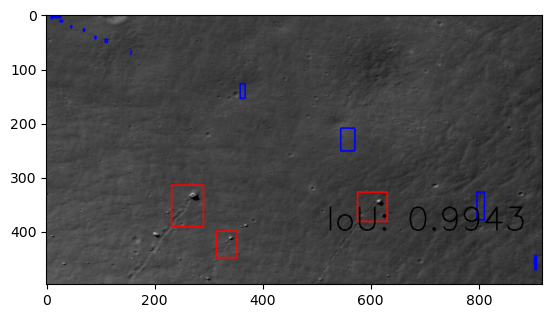

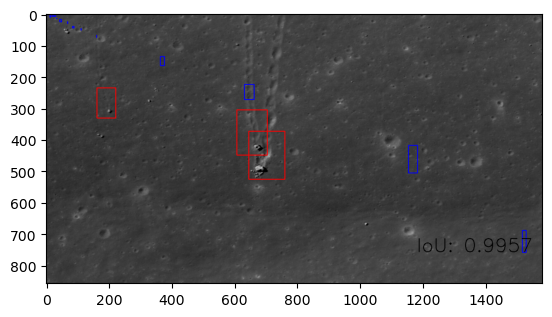

In [40]:
'''Random Image Predictons'''
try:
    random_num = input("ENter the num : ")
    plt.figure()

    for i in random_num.strip().split():
            image,true_bbox = (test_images[int(i)-1],test_bboxes[int(i)-1])
    #         print(image)
    #         print(true_bbox)
            """ Extracting the name """
            name = image.split("/")[-1]


            """ Reading the image """
            image = cv.imread(image, cv.IMREAD_COLOR)
            x = cv.resize(image, (width, height))
            x = (x - 127.5) / 127.5
            x = np.expand_dims(x, axis=0)

            """ Bounding box """
            True_bbox = true_bbox
            for cords in True_bbox:
                true_x1, true_y1, true_x2, true_y2=cords
                cv.rectangle(image, (int(true_x1), int(true_y1)), (int(true_x2), int(true_y2)), (255, 0, 0), 2) ## ACTUAL



            """ Prediction """
            pred_bbox= model.predict(x, verbose=0)
            pred_bbox = pred_bbox[0]
    #         Pred_bbox=pred_bbox.numpy()

            for cords in pred_bbox:

                """ Rescale the bbox points. """
                pred_x1 = int(cords[0] * image.shape[1])
                pred_y1 = int(cords[1] * image.shape[0])
                pred_x2 = int(cords[2] * image.shape[1])
                pred_y2 = int(cords[3] * image.shape[0])



                """ Plot bbox on image """

                image = cv.rectangle(image, (pred_x1, pred_y1), (pred_x2, pred_y2), (0, 0, 255), 2) ## PREDICTED

            """ Calculate IoU """
            iou,mean_iou = cal_iou(true_bbox, pred_bbox)

            """ Plot IoU on image """
            x = image.shape[1]-400
            y = image.shape[0]-100
            font_size = 2
            cv.putText(image, f"IoU: {iou:.4f}", (x, y), cv.FONT_HERSHEY_SIMPLEX, font_size, ([0,0,0]), 2)

    #         """ Showing the image """
            plt.figure()

            plt.imshow(image)
except IndexError:

    print("Please Enter values within range 1-17")
    



In [39]:
""" Mean IoU """
score = np.mean(mean_iou, axis=0)
# mean_acc = accuracy_score(test_labels, pred_labels)
print(f"Mean IoU: {score:.4f}")

Mean IoU: 0.5744
